<a href="https://colab.research.google.com/github/Sakiba1705/Vision-Transformer-Approach-Melanoma-Detection/blob/main/Melanoma_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio


In [ ]:
import gradio as gr

In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.__version__

'2.1.0+cu118'

#Load libraries

In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

Checking for device

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakibaakter1911359","key":"4be5d3cb6a8cc5171ec15f15bc79430d"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d drscarlat/melanoma

100% 5.25G/5.26G [00:56<00:00, 177MB/s]
100% 5.26G/5.26G [00:56<00:00, 100MB/s]


In [ ]:
! unzip /content/melanoma.zip

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

#Transforms

In [ ]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

#Path for training and testing directory

In [ ]:
train_path='/content/dermmel/DermMel/train_sep'
test_path='/content/dermmel/DermMel/test'

#Create Dataloader

In [ ]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=256, shuffle=True
)

categories

In [ ]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['Melanoma', 'NotMelanoma']


#Build CNN Network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter ((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features= 32*75*75,out_features=num_classes)



    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output



In [ ]:
model=ConvNet(num_classes=2).to(device)

#Optmizer and loss function

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

#Calculating the size of training and testing images

In [ ]:
train_count=len(train_loader.dataset)
test_count=len(test_loader.dataset)

In [ ]:
print(train_count,test_count)

10682 3561


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

#Model training and saving the best model

In [ ]:
best_accuracy=0.0

for epoch in range(num_epochs):

    #Evaluation on training dataset

    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset

    model.eval()

    test_accuracy=0.0
    test_loss = 0.0

    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)

        test_loss += loss.cpu().data * images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy=test_accuracy/test_count
    test_loss = test_loss / test_count
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Test Loss: ' + str(test_loss)+' Test Accuracy: '+str(test_accuracy))

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy




Epoch: 0 Train Loss: tensor(4.9271) Train Accuracy: 0.7158771765586969 Test Loss: tensor(1.7045) Test Accuracy: 0.7711317045773659
Epoch: 1 Train Loss: tensor(1.0094) Train Accuracy: 0.7877738251263808 Test Loss: tensor(0.6134) Test Accuracy: 0.7492277450154451
Epoch: 2 Train Loss: tensor(1.1641) Train Accuracy: 0.7880546714098483 Test Loss: tensor(0.7888) Test Accuracy: 0.8152204436955911
Epoch: 3 Train Loss: tensor(1.1890) Train Accuracy: 0.7982587530425014 Test Loss: tensor(0.7446) Test Accuracy: 0.7525975849480483
Epoch: 4 Train Loss: tensor(0.5692) Train Accuracy: 0.8387942332896461 Test Loss: tensor(0.2815) Test Accuracy: 0.806234203875316
Epoch: 5 Train Loss: tensor(0.4740) Train Accuracy: 0.8548024714472945 Test Loss: tensor(0.3477) Test Accuracy: 0.8351586632968268
Epoch: 6 Train Loss: tensor(0.5592) Train Accuracy: 0.8524620857517319 Test Loss: tensor(0.7988) Test Accuracy: 0.8475147430497051
Epoch: 7 Train Loss: tensor(0.5658) Train Accuracy: 0.8574237034263247 Test Loss: te

In [ ]:
import matplotlib.pyplot as plt

#Classification report and Confusion matrix

Accuracy: 83.35%
Classification Report:
              precision    recall  f1-score   support

    Melanoma       0.84      0.82      0.83      1781
 NotMelanoma       0.82      0.85      0.84      1780

    accuracy                           0.83      3561
   macro avg       0.83      0.83      0.83      3561
weighted avg       0.83      0.83      0.83      3561



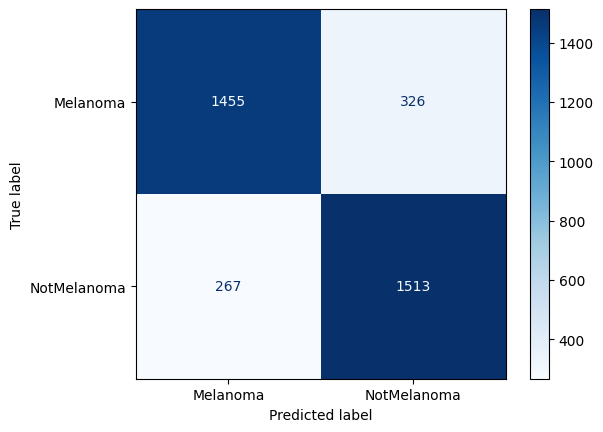

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test_loader to get predictions and true labels
model.eval()
for images, labels in test_loader:
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = labels.cuda()

    outputs = model(images)
    _, predictions = torch.max(outputs.data, 1)

    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, f1-score, and support
report = classification_report(true_labels, predicted_labels, target_names=classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Calculate accuracy
accuracy = np.trace(confusion) / np.sum(confusion)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(report)


# Plot the loss and accuracy curves

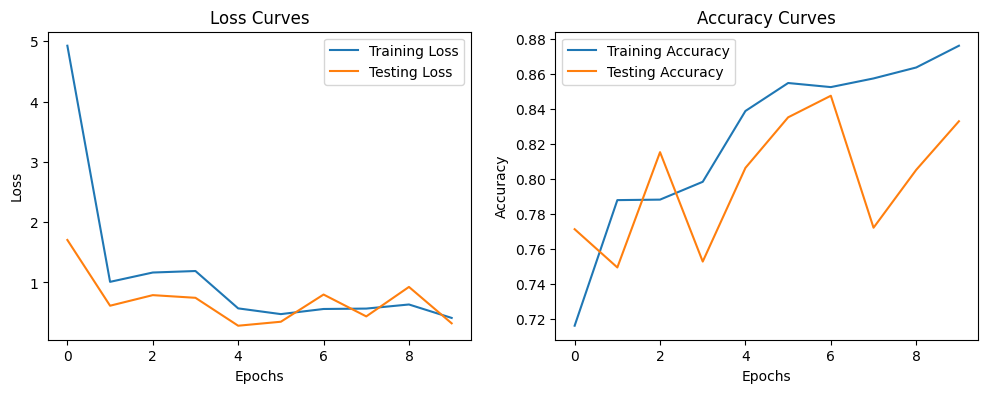

In [ ]:
# Plot the loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

# Load the trained model for make prediction

In [ ]:
model = ConvNet(num_classes=2).to(device)
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()


ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=2, bias=True)
)

#Preprocess the input image

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transformer(image).unsqueeze(0)  # Add a batch dimension
    return image.to(device)


#Build prediction function

In [ ]:
def predict_image(image_path):

    input_image = preprocess_image(image_path)

    # Make a prediction
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(input_image)
        probabilities = torch.softmax(output, dim=1)  # Get class probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Get the predicted class index

    # Return the predicted class and probabilities
    return predicted_class, probabilities[0]


#Make predictions

In [ ]:
image_path_to_predict = '/content/DermMel/test/Melanoma/AUG_0_1001.jpeg'
predicted_class, probabilities = predict_image(image_path_to_predict)

print(f'Predicted Class: {classes[predicted_class]}')
print(f'Class Probabilities: {probabilities}')


Predicted Class: Melanoma
Class Probabilities: tensor([0.9442, 0.0558], device='cuda:0')


#Deploy on webapp

In [ ]:
import torch
from PIL import Image
from torchvision.transforms import transforms

# Define the class labels
class_labels = ['Melanoma', 'NotMelanoma']

# Load the trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNet(num_classes=2).to(device)
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()

# Define the transformation for the input image
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define a function to preprocess the image and make predictions
def classify_image(image):
    # Preprocess the input image
    image = Image.fromarray(image)
    image = transformer(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make a prediction
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return class_labels[predicted_class], float(probabilities[0][predicted_class])

# Create a Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs="image",
    outputs=["text", "number"],
    title="Skin Lesion Classifier",
    description="Upload an image to classify it as Melanoma or NotMelanoma.",
    interpretation='default'
    #live=True
)

# Launch the Gradio web app
iface.launch(debug='True')


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://bf55156a280226cf6d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
